# Apstraktna sintaksna stabla - izrada _mini_ programskog jezika

U ovom radu bilo je potrebno implementirati mini programski jezik koji podržava nekoliko funkcionalnosti koje zapravo ima svaki programski jezik. Također bilo je potrebno napraviti jednostavni vizualizator apstraktnih sintaksnih stabala (AST, eng. abstract syntax tree).


Apstraktna stabla se baziraju na korjenskim stablima iz teorije grafova gdje unutrašnje vrhove predstavljaju operatori (+, -, *, /), a listove predstavljaju operandi (2, 5, 4). Apstraktna sintaksna stabla se koriste za određivanje redoslijeda izvođenja operacija i za prikaz unutrašnje strukture programskog jezika te predstavljaju temeljni dio svakog interpretera. 


Mini programski jezik je trebao podržavati sljedeće funkcionalnosti: 
* Rad s binarnim aritemetičkim operatorima (+, -, *, /)
* Inicijalizaciju varijabli (npr. x=2, y=3).
* IF-THEN-ELSE izraz


Zadatke je bilo potrebno implementirati u bilo kojem programskom jeziku te smo sukladno tome koristili Python koji sadrži biblioteke za izradu apstraktnih sintaksnih stabala. Za vizualizaciju, odnosno grafički prikaz stabala, smo koristili 3rd-party biblioteku Graphviz. Rješenje zadataka je napravljeno kao IPython bilježnica unutar open-source web aplikacije Jupyter Notebook. U daljnjem radu bilo je potrebno riješiti 4 zadatka koristeći Lexer i Parser koji će u nastavku biti objašnjeni. 


Programski kod nalazi se na sljedećoj GitHub poveznici - https://github.com/marzekan/AST_mini_programski_jezik

## Lexer

Lexseri se koriste kako bi prepoznale riječi koji se koriste u mini programskom jeziku, odnosno u jeziku koji sami stvaramo. Korištenje reguralnih izraza je dobar način na koji je moguće uvesti jezične strukture.

In [54]:
from rply import LexerGenerator
import re

import warnings
warnings.filterwarnings('ignore')

Za kreiranje lexer-a i parser-a koristili smo _Python_ modul _rply_ (https://rply.readthedocs.io/en/latest/) koji sadrži korisne klase kao što su _LexerGenerator_ i _ParserGenerator_. Navedenim klasama kreirali smo leksigrafske izraze (tokene) i sintaksna pravila jezika.

Sljedeći programski isječak sadrži deklaracije leksičkih tokena koje naš programki jezik poznaje. Pomoću lg.add(_name_ , _value_ ) metode kreirali smo nekolicinu _tokena_ tako da smo kao prvi parametar proslijedili naziv ( _name_ ) tokena te definirali njegovu točnu vrijednost ( _value_ ) pomoću regularnih izraza.

In [55]:
lg = LexerGenerator()

lg.add("NUMBER", r'\d+')
lg.add("PLUS", r'\+')
lg.add("MINUS", r'\-')
lg.add("MULT", r'\*')
lg.add("DIV", r'\/')

lg.add("MOD", r'\b\%\b')

lg.add("LPAR", r'\(')
lg.add("RPAR", r'\)')

lg.add("EQ", r'\b\==\b')
lg.add("NEQ", r'\b\!=\b')
lg.add("LESSTH", r'\b\<\b')
lg.add("GREATTH", r'\b\>\b')
lg.add("LESSEQ", r'\b\<=\b')
lg.add("GREATEQ", r'\b\>=\b')

lg.add("IF", r'\b(\w?IF\w?)\b')
lg.add("ELSE", r'\b(\w?ELSE\w?)\b')
lg.add("THEN", r'\b(\w?THEN\w?)\b')

lg.add("IDENTIFIER", re.compile(r'\w+?', re.MULTILINE))
lg.add("ASSGN", r'\b\=\b')

lg.ignore(r'\s+')

KEYWORDS = ['IF', 'THEN', 'ELSE']
OPERATORS = ['PLUS', 'MINUS', 'MULT', 'DIV']

lexer = lg.build()

Programski isječci u sljedeće tri ćelije deklariraju klase _Number_ i _BinaryOp_. _Number_ klasa definira cijele brojeve kao temeljni izraz _mini_ programskog jezika dok _BinaryOp_ definira predložak svih binarnih opercija.



In [56]:
from rply.token import BaseBox

In [57]:
class Number(BaseBox):
    def __init__(self, value):
        self.value = value
        
    def __repr__(self):
        return f'{self.value}'

In [58]:
class BinaryOp(BaseBox):
    def __init__(self, left, op_tok, right):
        self.left = left
        self.op_tok = op_tok
        self.right = rightb
        
    def __repr__(self):
        return f'({self.left}, {self.op_tok}, {self.right})'

## Parser

Parseri se koriste kako bi se prepoznale strukture jezičnih izraza. Prilikom izvođenja parsera, parser uzima ulazne podatke u obliku niza znakova, provjerava ih prema postavljenih sintaksnih pravila napisanog jezika i pretvara ih u pripadne reprezente, točnije riječi koje lexser prepozna stavnja u kontekst prema postavljenim sintaksnim pravilima. Kako bi uspješno izradili zadatak koristili smo BNF (Backus-Naur formu) kako bi točno odredili sintaksna pravila _mini_ jezika.

Sintaksna pravila jezika definirana su u dekoratorima tipa _pg.production()_. Dekoratori sadrže točna pravila prema kojima parser gradi sintaksno stablo, dok same funkcije vraćaju definirane vrijednosti izraza.

In [59]:
from rply import ParserGenerator

In [60]:
pg = ParserGenerator(
    
    ['NUMBER', 'PLUS', 'MINUS', 'MULT', 'DIV',
     'LPAR', 'RPAR', 'IDENTIFIER', 'ASSGN', 'EQ',
     'IF', 'ELSE', 'THEN', 'NEQ', 'LESSTH', 'GREATTH',
     'LESSEQ', 'GREATEQ', 'MOD'
    ],
    
    precedence=[
        ('left', ['PLUS', 'MINUS']),
        ('left', ['MULT', 'DIV'])
    ]
)

@pg.production('expression : IDENTIFIER ASSGN expression')
def variable_assign(p):
    return (p[0].value,p[2])


@pg.production('expression : LPAR expression RPAR')
def expression_perens(p):
    return p[1]

@pg.production('expression : expression PLUS expression')
@pg.production('expression : expression MINUS expression')
@pg.production('expression : expression MULT expression')
@pg.production('expression : expression DIV expression')
@pg.production('expression : expression EQ expression')
@pg.production('expression : expression NEQ expression')
@pg.production('expression : expression LESSTH expression')
@pg.production('expression : expression GREATTH expression')
@pg.production('expression : expression LESSEQ expression')
@pg.production('expression : expression GREATEQ expression')
@pg.production('expression : expression MOD expression')
def expression(p):
    
        left = p[0]
        right = p[2]
        operator = p[1]
            
        return (left, operator.name, right)  


@pg.production('expression : IF expression THEN expression ELSE expression')
def cond_expression(p):
    return (p[0].name,p[1],p[3],p[5])
            
@pg.production('expression : NUMBER')
def number(p):
        return Number(p[0].value)
    
@pg.production('expression : IDENTIFIER')
def var_exp(p):
    return p[0].value

@pg.production('expression : expression expression', precedence='MULT')
def implicirano_mnozenje(p):
    return (p[0],'MULT', p[1])

Metoda u narednoj ćeliji gradi parser prema ranije definiranim pravilima. Zatim, u zasebnu listu pohranjuje deklarirane varbijable (ako postoje) i njihove vrijednosti (u obliku _tuple_ strukture). Ako izraz sadrži varijable, sljedeći korak je zamjeniti imena varijabli s njihovim vrijednostima u izrazu te kreira apstraktno stablo.

Metoda vraća apstraktno sintaksno stablo u obliku ugnježđenih _tuple_ struktura kao rezultat.

In [61]:
def parse_tree(line):
    parser = pg.build()
    
    line = line.split('\n')
    line = filter(None, line)

    # lista tuple-a koji su varijable i njihove vrijednosti.
    variables = []
    expression = None

    for l in line:
        
        expr = parser.parse(lexer.lex(l))
        
        if len(expr) == 2:
            variables.append(expr)
        
        else:
            expression = l
            
    print("Prikaz izraza:")
    print(expression, '\n')

    for var in variables:
        expression = expression.replace(var[0], str(var[1]))

    print('Lista iniciranih varijabli i njihove vrijednosti:')
    print(variables, '\n')
    
    print('Prikaz izraza gdje su varijable (ako postoje) zamijenjene s njihovim vrijednostima:')
    print(expression, '\n')

    tree = parser.parse(lexer.lex(expression))
    
    print('Prikaz apstraktnog stabla u obliku ugnježđenih tuple struktura:')
    print(tree)
    
    return tree

## Crtanje apstraktnog stabla

Ovo poglavlje sadrži metode za crtanje apstraktnih stabala pomoću _python graphviz_ modula. Metode su pisane rekurzivno tako da se stablo gradi neovisno o broju ugnježđenih razina.

Prva metoda _build_graph_ jednostavno prolazi kroz apstraktno stablo te kreira vrhove prema operatorima i operandima, te ih međusobno veže kako je parserom defininirano.

Metoda _build_if_ gradi stablo kojemu će korijen uvijek biti 'IF' vrh te će uvijek sadržavati vrhove 'True' (THEN) i 'False' (ELSE) kao alternative izvršavanja. Ostatak stabla gradi se pomoću _build_graph_.

In [62]:
from graphviz import Graph

In [63]:
from random import random

In [64]:
def build_graph(gr, tup):
    
    n = random()
    
    for el in tup:
        
        if isinstance(el, str):
            parent = str(n)
            gr.node(parent,el)
            
            n=random()
            
            for i in (tup[tup.index(el)-1], tup[tup.index(el)+1]):
                if isinstance(i, tuple):
                    child = build_graph(gr,i)
                    gr.edge(parent,child)

                if isinstance(i, Number):
                    child = str(n)
                    gr.node(child, i.value)
                    gr.edge(parent,child)
                    
                    n=random()
                    
            return parent

In [65]:
def build_if(gr, tup):
    
    if len(tup)==4:
        gr.node('if','IF')
        gr.node('then', 'True')
        gr.node('else','False')

        gr.edge('if', 'then')
        gr.edge('if', 'else')
        
    for elem in tup[1:]:
        child = build_graph(gr, elem)
        
        if tup.index(elem) == 1:
            gr.edge('if', child)
            
        if tup.index(elem) == 2:
            gr.edge('then', child)
            
        if tup.index(elem) == 3:
            gr.edge('else', child)
        

# Zadaci

Ovo poglavlje sadrži rješenja zadanih zadataka. Za rješavanje korišten je programski kod iz ranijih poglavlja.

## Zadatak 1

Napisati program tako da radi za sljedeci izraz:
                    2*(5-3)+3*(10/2)

In [66]:
zadatak1 = "2*(5-3)+3*(10/2)"

Prikaz _tokena_ koje je Lexer pronašao.

In [67]:
for token in lexer.lex(zadatak1):
    print(token)

Token('NUMBER', '2')
Token('MULT', '*')
Token('LPAR', '(')
Token('NUMBER', '5')
Token('MINUS', '-')
Token('NUMBER', '3')
Token('RPAR', ')')
Token('PLUS', '+')
Token('NUMBER', '3')
Token('MULT', '*')
Token('LPAR', '(')
Token('NUMBER', '10')
Token('DIV', '/')
Token('NUMBER', '2')
Token('RPAR', ')')


Generirano sintaksno stablo u obliku ugnježđenih _tuple_ -a

In [68]:
ast_stablo = parse_tree(zadatak1)

Prikaz izraza:
2*(5-3)+3*(10/2) 

Lista iniciranih varijabli i njihove vrijednosti:
[] 

Prikaz izraza gdje su varijable (ako postoje) zamijenjene s njihovim vrijednostima:
2*(5-3)+3*(10/2) 

Prikaz apstraktnog stabla u obliku ugnježđenih tuple struktura:
((2, 'MULT', (5, 'MINUS', 3)), 'PLUS', (3, 'MULT', (10, 'DIV', 2)))


Prikaz apstraktnog sintaksnog stabla izrađenog pomoću _Graphviz_ modula.

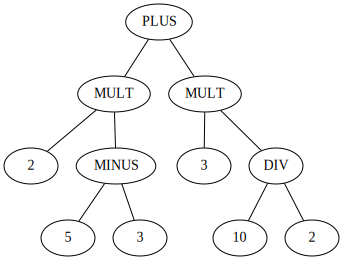

In [69]:
# Iniciranje graphviz.Graph objekta.
graf = Graph()

build_graph(graf, ast_stablo)

# Crtanje grafa.
graf

## Zadatak 2

Dopuniti programski kod iz prvog zadatka tako da podržava inicijalizaciju varijabli:

                    x = 2
                    y = 3
          (x*2)+(y-4)-((7+4)*x-y*(10+x))

In [70]:
zadatak2 = '''
        x=2
        y=3
(x*2)+(y-4)-((7+4)*x-y*(10+x))
'''

In [71]:
ast_stablo2 = parse_tree(zadatak2)

Prikaz izraza:
(x*2)+(y-4)-((7+4)*x-y*(10+x)) 

Lista iniciranih varijabli i njihove vrijednosti:
[('x', 2), ('y', 3)] 

Prikaz izraza gdje su varijable (ako postoje) zamijenjene s njihovim vrijednostima:
(2*2)+(3-4)-((7+4)*2-3*(10+2)) 

Prikaz apstraktnog stabla u obliku ugnježđenih tuple struktura:
(((2, 'MULT', 2), 'PLUS', (3, 'MINUS', 4)), 'MINUS', (((7, 'PLUS', 4), 'MULT', 2), 'MINUS', (3, 'MULT', (10, 'PLUS', 2))))


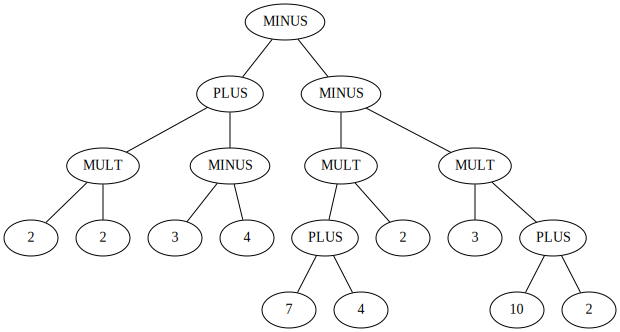

In [72]:
graf2 = Graph()

build_graph(graf2, ast_stablo2)

graf2

## Zadatak 3

Proširite programski kod tako da podržava IF-THEN-ELSE klauzulu:
                    
                    IF x==y THEN y/x ELSE x/y

In [73]:
zadatak3 = '''
x=10
y=12
IF x==y THEN y/x ELSE x/y
'''

In [74]:
ast_stablo3 = parse_tree(zadatak3)

Prikaz izraza:
IF x==y THEN y/x ELSE x/y 

Lista iniciranih varijabli i njihove vrijednosti:
[('x', 10), ('y', 12)] 

Prikaz izraza gdje su varijable (ako postoje) zamijenjene s njihovim vrijednostima:
IF 10==12 THEN 12/10 ELSE 10/12 

Prikaz apstraktnog stabla u obliku ugnježđenih tuple struktura:
('IF', (10, 'EQ', 12), (12, 'DIV', 10), (10, 'DIV', 12))


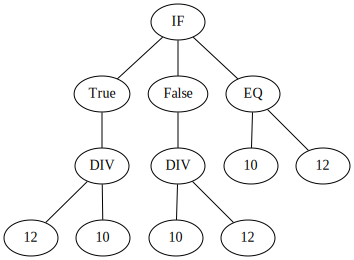

In [75]:
graf3 = Graph()

build_if(graf3, ast_stablo3)

graf3

## Zadatak 4

Proširiti program tako da podržava sljedeću funkcionalnost:
* Ugraditi dodatne operacije:
    * Modularno dijeljenje
    * Ostali operatori uspoređivanja (<, >, !=, <=, >=)

In [76]:
zadatak4='''
2<3
5>4
3!=22
1<=1
6>=9
10%2
'''

In [77]:
stabla = []

zadatak4 = zadatak4.split('\n')
zadatak4 = filter(None, zadatak4)

for linija in zadatak4:
    stabla.append(parse_tree(linija))

Prikaz izraza:
2<3 

Lista iniciranih varijabli i njihove vrijednosti:
[] 

Prikaz izraza gdje su varijable (ako postoje) zamijenjene s njihovim vrijednostima:
2<3 

Prikaz apstraktnog stabla u obliku ugnježđenih tuple struktura:
(2, 'LESSTH', 3)
Prikaz izraza:
5>4 

Lista iniciranih varijabli i njihove vrijednosti:
[] 

Prikaz izraza gdje su varijable (ako postoje) zamijenjene s njihovim vrijednostima:
5>4 

Prikaz apstraktnog stabla u obliku ugnježđenih tuple struktura:
(5, 'GREATTH', 4)
Prikaz izraza:
3!=22 

Lista iniciranih varijabli i njihove vrijednosti:
[] 

Prikaz izraza gdje su varijable (ako postoje) zamijenjene s njihovim vrijednostima:
3!=22 

Prikaz apstraktnog stabla u obliku ugnježđenih tuple struktura:
(3, 'NEQ', 22)
Prikaz izraza:
1<=1 

Lista iniciranih varijabli i njihove vrijednosti:
[] 

Prikaz izraza gdje su varijable (ako postoje) zamijenjene s njihovim vrijednostima:
1<=1 

Prikaz apstraktnog stabla u obliku ugnježđenih tuple struktura:
(1, 'LESSEQ', 1)
Prikaz 

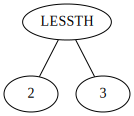

In [78]:
graf = Graph()
build_graph(graf, stabla[0])
graf

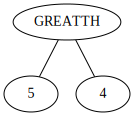

In [79]:
graf = Graph()
build_graph(graf, stabla[1])
graf

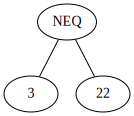

In [80]:
graf = Graph()
build_graph(graf, stabla[2])
graf

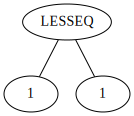

In [81]:
graf = Graph()
build_graph(graf, stabla[3])
graf

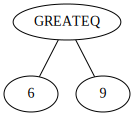

In [82]:
graf = Graph()
build_graph(graf, stabla[4])
graf

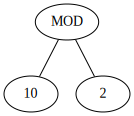

In [83]:
graf = Graph()
build_graph(graf, stabla[5])
graf